In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Distribution de la température dans un appartement d'un immeuble aux plusieurs étages


# Équation de transfert de chaleur:
# k*(d^2 T(x,y)/dx^2 + d^2 T(x,y)/dy^2)+S=0


# Conditions aux limites:

# (1) Condition convective (de Robin) à x=0 et à x=Lx (faces externes du mur):
# -k*dT(x=0,y)/dx=-h*(T-Ta)
# -k*dT(x=L,y)/dx=h*(T-Ta)
Ta=-20; #oC

# (2) Condition de Dirichlet sur le plafond et sur le plancher
# T(x, y=0 ou y=Ly)=Tp
Tp=20; #oC

# Dimensions d'appartement
Lx=4; #[m]
Ly=2.4;  #[m]

# Parametres d'un mur d'isolation thermique
Lm=0.4; #m ; Épaisseur du mur en brique
km=0.85;#W/(m*K); La conductivité thermique de la brique
h=1; #W/(m^2*K); Coefficient de transfert thermique sur les surfaces extérieures du mur

# Paramètres de l'air qui remplit l'appartement
ka=0.024;

fact_ar = np.array([8.0], dtype=np.double); # Matrice pleine
d_ar=np.zeros(fact_ar.size,dtype=np.double);
tini_ar=np.zeros(fact_ar.size,dtype=np.double);
tinv_ar=np.zeros(fact_ar.size,dtype=np.double);
mem_ar=np.zeros(fact_ar.size,dtype=np.double);
Tm_ar=np.zeros(fact_ar.size,dtype=np.double);
Err_ar=np.zeros(fact_ar.size-1,dtype=np.double);
d_Err_ar=np.zeros(fact_ar.size-1,dtype=np.double);

ci=-1;
for fact in fact_ar:
    ci=ci+1;
    d=0.1*fact;    #Pas de discrétisation en [m]
    print('Pas de discritization dx=dy=',d,'m')
    d_ar[ci]=d;
    Nx=int(np.rint(Lx/d+1)); # Nombre de nœuds le long de X
    Ny=int(np.rint(Ly/d+1)); # Nombre de nœuds le long de Y
    
    
    tic=time.time_ns();
    
    # Initialisation de la source de chaleur, de la conductivité thermique et de la matrice
    S=np.zeros((Ny,Nx),dtype=np.double);
    k=np.zeros((Ny,Nx),dtype=np.double);
    for i in np.arange(1,Ny+1,1): #i=1,..,Ny - numérotation des nœuds sur un maillage physique
        y=(i-1)*d;
        for j in np.arange(1,Nx+1,1): #j=1,..,Nx - numérotation des nœuds sur un maillage physique
            x=(j-1)*d;
            
            # Sourse volumique de chaleur q[W/m^3] d'épaisseur dL.
            # La source est intégrée dans les parties intérieures du mur à x=Lm et à x=Lx-Lm et
            # il occupe les tiers du mur dans la direction verticale
            dL=0.1;
            q=1.0e3;# W/m^3;
            if ((x<=Lm) and (y<=Ly/3+Lm) and (y>Lm)):
                # À l'intérieur de l'élément chauffant
                S[i-1,j-1]=q*np.exp(-((x-Lm)/dL)**2);
            elif ((x>=(Lx-Lm)) and (y<=Ly/3+Lm) and (y>Lm)):
                # À l'intérieur de l'élément chauffant
                S[i-1,j-1]=q*np.exp(-((Lx-Lm-x)/dL)**2);
            else:
                # À l'extérieur de l'élément chauffant
                S[i-1,j-1]=0.0;
            
            # L'espace de vie de l'appartement est délimité par
            # les parois d'épaisseur Lm à tous les quatre côtés
            if ((x<=Lm) or (x>=(Lx-Lm)) or (y<=Lm) or (y>=(Ly-Lm))):
                # À l'intérieur du mur
                k[i-1,j-1]=km;
            else:
                # À l'intérieurde de l'appartement
                k[i-1,j-1]=ka;
               
    M=np.zeros((Nx*Ny,Nx*Ny),dtype=np.double);
    b=np.zeros((Nx*Ny,1),dtype=np.double);
    T=np.zeros((Nx*Ny,1),dtype=np.double);
    Tr=np.zeros((Ny,Nx),dtype=np.double);
    
    for i in np.arange(1,Ny+1,1):
        for j in np.arange(1,Nx+1,1):
            # remplir la ligne pl de la matrice M
            pl=(i-1)*Nx+j
            if (((i>1) and (i<Ny)) and ((j>1) and (j<Nx))):
                # noeud qui est strictement à l'intérieur de la cellule de simulation
                pc=pl
                M[pl-1,pc-1]=-4 # contribution de noeud (i,j)
                pc=(i-1)*Nx+j-1
                M[pl-1,pc-1]=1 # contribution de noeud (i,j-1)
                pc=(i-1)*Nx+j+1
                M[pl-1,pc-1]=1 # contribution de noeud (i,j+1)
                pc=(i-2)*Nx+j
                M[pl-1,pc-1]=1 # contribution de noeud (i-1,j)
                pc=(i)*Nx+j
                M[pl-1,pc-1]=1 # contribution de noeud (i+1,j)
                b[pl-1]=-d**2*S[i-1,j-1]/k[i-1,j-1]
            elif (i==1 and j!=1):
                # noeud sur le plafond y=0
                pc=pl
                M[pl-1,pc-1]= 3+2*d*h/k[i-1,j-1]# contribution de noeud (1,j)
                pc=(j-1)*Ny+i+1
                print(pc, i, j)
                M[pl-1,pc-1]=-4 # contribution de noeud (Nx,j)
                pc=(j-1)*Ny+(i+1)*2
                M[pl-1,pc-1]=1 # contribution de noeud (2Nx,j)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1]

            elif (i==Ny):
                # noeud sur le plancher y=Ly
                pc=pl
                M[pl-1,pc-1]= 3+2*d*h/k[i-1,j-1]# contribution de noeud (Nx,j)
                pc=(j-1)*Ny+i-1
                M[pl-1,pc-1]=-4 # contribution de noeud (Nx,j)
                pc=(j-1)*Ny+i-2
                M[pl-1,pc-1]=1 # contribution de noeud (2Nx,j)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1]

            elif (j==1):
                # noeud à la surface externe du mur x=0
                pc=pl
                M[pl-1,pc-1]=3+2*d*h/k[i-1,j-1] # contribution de noeud (i,1)
                pc=(i-1)*Nx+j+1
                M[pl-1,pc-1]=-4 # contribution de noeud (i,2)
                pc=(i-1)*Nx+j+2
                M[pl-1,pc-1]=1 # contribution de noeud (i,3)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1]
            elif (j==Nx):
                # noeud à la surface externe du mur x=Nx
                pc=pl
                M[pl-1,pc-1]=3+2*d*h/k[i-1,j-1] # contribution de noeud (i,Nx)
                pc=(i-1)*Nx+j-1
                M[pl-1,pc-1]=-4 # contribution de noeud (i,Nx-1)
                pc=(i-1)*Nx+j-2
                M[pl-1,pc-1]=1 # contribution de noeud (i,Nx-2)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1]
            elif ((j-1)*d == Lm or (j-1)*d == Ly-Lm):
                pc=pl
                M[pl-1,pc-1]=3 # contribution de noeud (i,1)
                pc=(i-1)*Nx+j+1
                M[pl-1,pc-1]=-4# contribution de noeud (i,2)
                pc=(i-1)*Nx+j+2
                M[pl-1,pc-1]=1 # contribution de noeud (i,3)
                b[pl-1]= 0
            elif ((i-1)*d == Lm or (i-1)*d == Ly-Lm):
                pc=pl
                M[pl-1,pc-1]= 3# contribution de noeud (1,j)
                pc=(j-1)*Ny+i+1
                M[pl-1,pc-1]=-4 # contribution de noeud (2,j)
                pc=(j-1)*Ny+i+2
                M[pl-1,pc-1]=1 # contribution de noeud (3,j)
                b[pl-1]=0
            
            else:
                print('Erreur dans la définition de la matrice de coefficients')

    toc=time.time_ns()
    tini_ar[ci]=(toc-tic)/1.0e9; #temps en [s]  
    
    tic=time.time_ns()
    T=np.linalg.solve(M,b)
    toc=time.time_ns()
    tinv_ar[ci]=(toc-tic)/1.0e9; #temps en [s]  
    
    mem_ar[ci]=8*(Nx*Ny)**2
    
    Tr=np.reshape(T,(Ny,Nx),order='C')
    
    Tm_ar[ci]=Tr[int(np.rint(Ly/d/2+1))-1,int(np.rint(Lx/d/2+1))-1]; # température au milieu du domaine de calcul

print(Nx, Ny)

Pas de discritization dx=dy= 0.8 m
4.0 2.4000000000000004
4.0 2.4000000000000004
6 1 2
4.0 2.4000000000000004
10 1 3
4.0 2.4000000000000004
14 1 4
4.0 2.4000000000000004
18 1 5
4.0 2.4000000000000004
22 1 6
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
4.0 2.4000000000000004
6 4


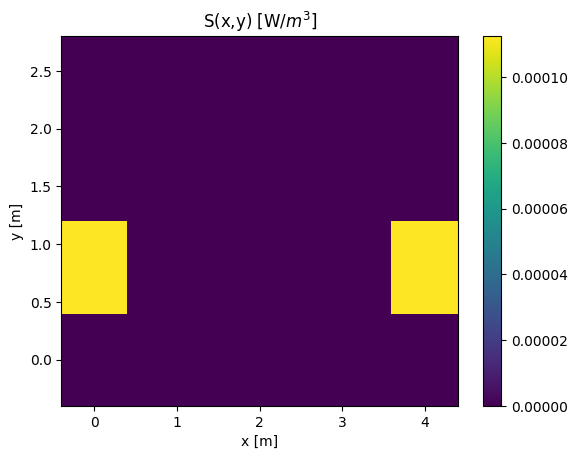

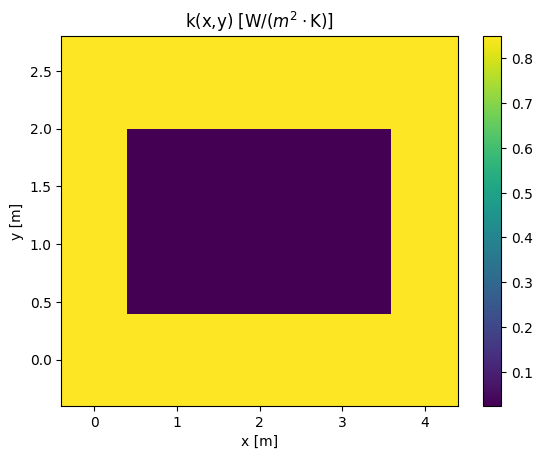

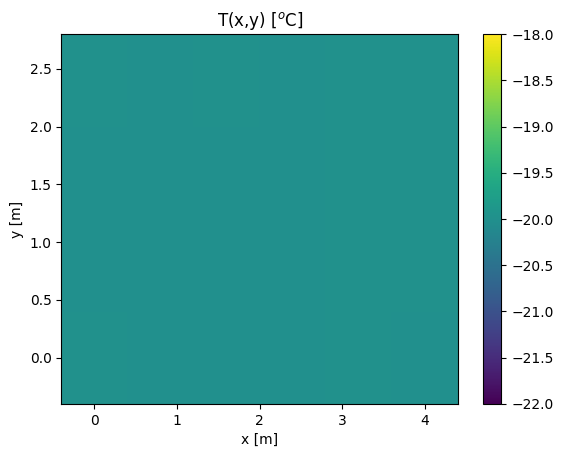

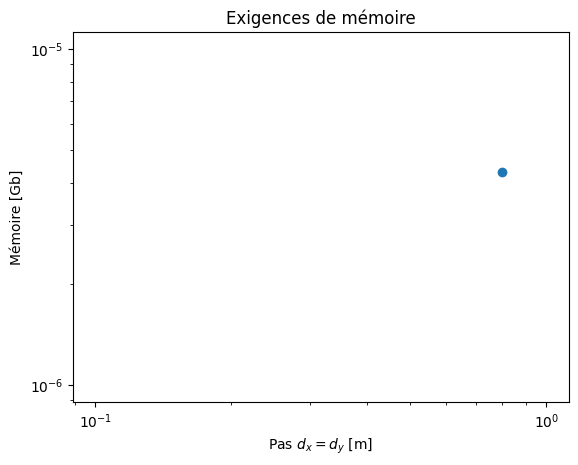

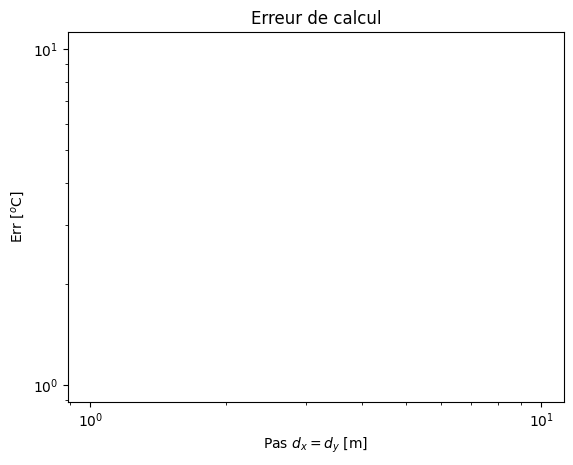

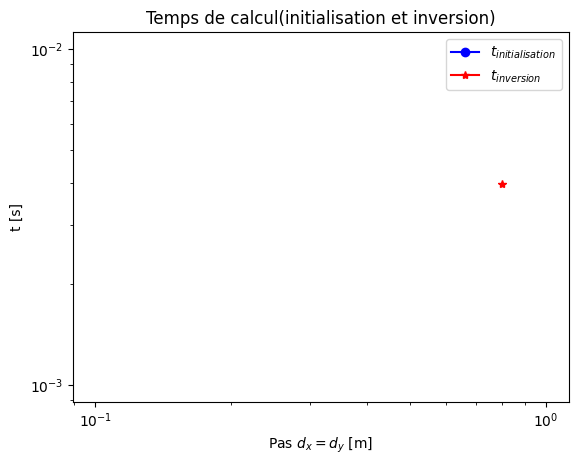

In [5]:
plt.figure(1)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,S);
plt.colorbar(mappable=None, cax=None, ax=None);
plt.title('S(x,y) [W/$m^3$]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(2)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,k);
plt.colorbar(mappable=None, cax=None, ax=None);
plt.title('k(x,y) [W/($m^2\cdot$K)]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(3)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,Tr);
plt.colorbar(mappable=None, cax=None, ax=None);
plt.title('T(x,y) [$^o$C]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(4)
plt.loglog(d_ar[::-1],mem_ar[::-1]/1024.0**3,'-o')
plt.title('Exigences de mémoire')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Mémoire [Gb]')

plt.figure(5)
Err_ar=abs(Tm_ar[:-1:]-Tm_ar[1::]);
d_Err_ar=d_ar[1::]; # Definiton d'erreur Err(delta)=|Tm(2*delta)-Tm(delta)|
plt.loglog(d_Err_ar[::-1],Err_ar[::-1],'-o')
plt.title('Erreur de calcul')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Err [$^o$C]')

plt.figure(6)
plt.loglog(d_ar[::-1],tini_ar[::-1],'-bo',d_ar[::-1],tinv_ar[::-1],'-r*')
plt.title('Temps de calcul(initialisation et inversion)')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('t [s]')
plt.legend(['$t_{initialisation}$','$t_{inversion}$'])
